In [141]:
import numpy as np
import pandas as pd
import pystan
from scipy.stats import norm, multivariate_normal, invwishart, invgamma, bernoulli
from statsmodels.tsa.stattools import acf
import datetime
import sys
import os

from tqdm.notebook import tqdm
from codebase.plot import * 
from codebase.data import * 
from codebase.file_utils import save_obj, load_obj

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
num_chains = 1
num_samples = 1000
num_warmup = 1000
num_iter = num_samples + num_warmup

In [152]:
log_dir = "./log/bin_sim_1factor/sim0/20191121_012750_bin_sim0_m1//"
data = load_obj('data', log_dir)
ps = load_obj('ps', log_dir)
load_sign = np.sign(np.mean(ps['beta'][0]))
ps.keys()

None


dict_keys(['beta', 'alpha', 'zz'])

In [4]:
print(open(log_dir+'model.txt').read())

data {
  int<lower=1> N;
  int<lower=1> K;
  int<lower=1> J;
  int<lower=0, upper=1> DD[N, J];
}

parameters {
  vector[J] alpha;
  matrix[J,K] beta;
  matrix[N,K] zz;
}

transformed parameters{
  matrix[N,J] yy;
  for (n in 1:N) yy[n,] = to_row_vector(alpha) + zz[n,] * beta';
}

model {
  to_vector(beta) ~ normal(0, 1);
  to_vector(alpha) ~ normal(0, 10);
  to_vector(zz) ~ normal(0, 1);
  for (j in 1:J) DD[, j] ~ bernoulli_logit(yy[, j]);
}



In [113]:
def order_data(data, zz, beta):
    load_sign = np.sign(np.mean(beta))
    J = data.shape[1]
    df = pd.DataFrame(data)
    df.columns = ['x'+str(i) for i in range(1,J+1)]
    df.insert(column='z', value=zz*load_sign, loc=0)
    return df.sort_values('z')


def exp_k(df, k, alpha, beta, num_gprs=10):
    load_sign = np.sign(np.mean(beta))
    N = df.shape[0]/num_gprs
    z_bar = np.mean(np.array_split(df,num_gprs)[k]['z'])
    y_bar = alpha + z_bar * beta * load_sign
    return np.round(expit(y_bar)*N,0)


def obs_k(df, k, num_gprs=10):
    return np.array_split(df,num_gprs)[k].drop('z',1).sum(0).values


def obs_star_k(df, k, alpha, beta, num_gprs=10):
    load_sign = np.sign(np.mean(beta))
    y_star = alpha +  np.outer(df.z, beta*load_sign)
    data_pred = pd.DataFrame(bernoulli.rvs(expit(y_star)))
    return np.array_split(data_pred,num_gprs)[k].sum(0).values


def G2(N, E, O):
    if (O != 0).all():
        return N*(O*np.log(O/E) + (1-O) * np.log((1-O)/(1-E)))
    else:
        return np.nan
        
def G2_item(N, E, O, item):
#     assert O[item] != 0
    return N*(O[item]*np.log(O[item]/E[item]) + (1-O[item]) * np.log((1-O[item])/(1-E[item])))
            

In [142]:
GG2 = np.empty((1000,10,6))
GG2_post = np.empty((1000,10,6))
N = 100
for i in tqdm(range(1000)):
    for k in range(10):
        df = order_data(data['D'], ps['zz'][i], ps['beta'][i])
        O = obs_k(df, k)
        Ostar = obs_star_k(df, k, ps['alpha'][i], ps['beta'][i]) 
        E = exp_k(df, k, ps['alpha'][i], ps['beta'][i]) 
        for item in range(6):
            if O[item] ==0:
                GG2[i,k,item] = np.nan
            else:
                GG2[i,k,item] = G2_item(N, E, O, item)
                
            if Ostar[item] ==0:
                GG2_post[i,k,item] = np.nan
            else:
                GG2_post[i,k,item] = G2_item(N, E, Ostar, item)               

/Users/itemgmt/miniconda3/envs/bayes-sem/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/Users/itemgmt/miniconda3/envs/bayes-sem/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/Users/itemgmt/miniconda3/envs/bayes-sem/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Users/itemgmt/miniconda3/envs/bayes-sem/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/Users/itemgmt/miniconda3/envs/bayes-sem/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in multiply


In [147]:
Des = np.empty(6)
for item in range(6):
    Des[item] = np.sum(pd.DataFrame(GG2[:,:,item]).sum(1) < pd.DataFrame(GG2_post[:,:,item]).sum(1))

In [170]:
np.round((Des/1000)*100,0)

array([52., 50., 49., 53., 49., 51.])

In [162]:
pd.DataFrame(GG2[:,:,5])

,0,1,2,3,4,5,6,7,8,9
0,NaN,0.000000,-66.058871,-2.952799,-1.080362,-5.080617,-1.359358,-0.607675,-0.596400,0.000000
1,NaN,NaN,-3.501053,-8.938356,-30.123311,-1.717931,-0.191613,-0.101845,-0.454328,-0.236658
2,NaN,NaN,-145.551583,-12.133747,-1.903358,-5.080617,-0.289115,-2.195777,-3.193863,-0.976810
3,NaN,NaN,-2.952799,-6.050075,-36.932606,-17.439138,-0.157424,-0.324798,-1.034056,-1.188342
4,NaN,NaN,-11.778304,-2.952799,-6.050075,-1.951897,-0.872885,-0.447306,0.000000,-0.778745
5,NaN,NaN,-16.989904,-54.826208,-58.778666,0.000000,-11.108702,-0.136261,-0.181964,-0.050670
6,NaN,NaN,0.000000,0.000000,-18.182375,-8.277250,-2.492343,-4.485189,-0.791687,-0.014285
7,NaN,NaN,0.000000,-14.618251,-18.182375,-0.754454,0.000000,-0.492867,-0.484667,-0.014780
8,NaN,-16.989904,-21.846060,-2.952799,-1.329629,-1.951897,-9.243224,-0.127244,0.000000,-0.256865
9,NaN,-6.566703,-28.768207,-8.938356,-15.635640,-0.598036,-0.289115,-0.141132,-0.555195,-0.191447


In [153]:
%%opts Layout [fig_size=200]
plots = []
for j in range(data['J']):
        plots.append(plot_trace(ps['beta'][:,j]*load_sign,
             true_value=data['beta'][j],
             title = 'Posterior distribution for beta(%s)'%(j)).\
                     options(fig_inches=8, aspect=3))
layout = hv.Layout(plots).options(show_title = True,
                                  vspace = .3,
                                  absolute_scaling=False,
                                  normalize=False) # use same y-range for all plots?

layout.cols(2)


:Layout
   .Overlay.Posterior_distribution_for_beta_left_parenthesis_0_right_parenthesis :Overlay
      .Curve.Samples    :Curve   [x]   (y)
      .Curve.True_Value :Curve   [x]   (y)
   .Overlay.Posterior_distribution_for_beta_left_parenthesis_1_right_parenthesis :Overlay
      .Curve.Samples    :Curve   [x]   (y)
      .Curve.True_Value :Curve   [x]   (y)
   .Overlay.Posterior_distribution_for_beta_left_parenthesis_2_right_parenthesis :Overlay
      .Curve.Samples    :Curve   [x]   (y)
      .Curve.True_Value :Curve   [x]   (y)
   .Overlay.Posterior_distribution_for_beta_left_parenthesis_3_right_parenthesis :Overlay
      .Curve.Samples    :Curve   [x]   (y)
      .Curve.True_Value :Curve   [x]   (y)
   .Overlay.Posterior_distribution_for_beta_left_parenthesis_4_right_parenthesis :Overlay
      .Curve.Samples    :Curve   [x]   (y)
      .Curve.True_Value :Curve   [x]   (y)
   .Overlay.Posterior_distribution_for_beta_left_parenthesis_5_right_parenthesis :Overlay
      .Curve.Samples    :Curve   [x]   (y)
      .Curve.True_Value :Curve   [x]   (y)

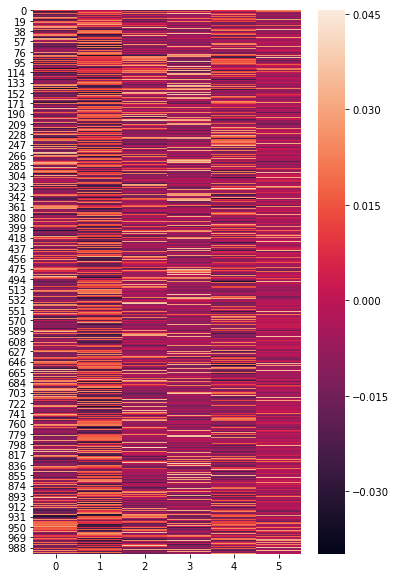

In [25]:
mu = np.mean(ps['uu'],0)
plt.figure(figsize=(6,10))
ax = sns.heatmap(mu, cbar = True )

In [26]:
print(np.round(np.mean(mu,0)*1e4, 2))
hv.Bars(np.mean(abs(mu),0)).options(color='blue', xrotation=90).options(fig_inches=8, aspect=3)

[-0.35  0.3   0.28  0.46  0.22 -0.69]


:Bars   [x]   (y)

In [9]:
print("Avg 0-900 = %.2f \nAvg 901-1000 = %.2f"%(np.mean(mu[:900])*1e3,np.mean(mu[900:])*1e3))

Avg 0-900 = -0.47 
Avg 901-1000 = 2.82


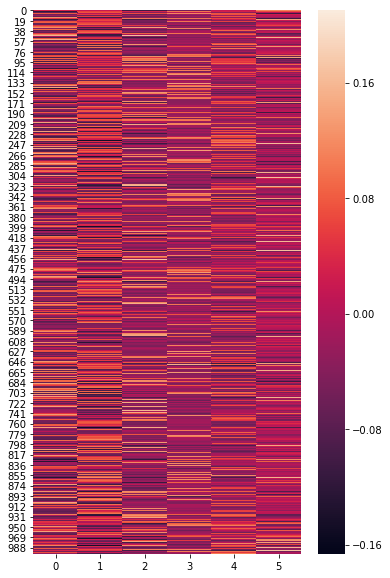

In [131]:
mu1 = np.mean(ps1['uu'],0)
plt.figure(figsize=(6,10))
ax = sns.heatmap(mu1, cbar = True )

In [132]:
print(np.round(np.mean(mu1,0)*1e4, 2))
hv.Bars(np.mean(abs(mu1),0)).options(color='blue', xrotation=90).options(fig_inches=8, aspect=3)

[ 4.36 -5.07  2.01 -3.42 -0.86  7.56]


:Bars   [x]   (y)

In [16]:
print("Avg 0-900 = %.2f \nAvg 901-1000 = %.2f"%(np.mean(mu[:900])*1e3,np.mean(mu[900:])*1e3))

Avg 0-900 = -0.47 
Avg 901-1000 = 2.82


In [12]:
np.mean(mu[:900],0)*1e3

array([-0.51651523,  0.27647594, -0.59786509, -0.29971204, -1.14736767,
       -0.52713823])

In [17]:
np.mean(mu[900:],0)*1e3

array([ 6.24278446, -0.51357661,  1.90470316, -3.31539368,  9.28697307,
        3.34353571])

In [21]:
data['y'][900:, 3:]

array([[-2.88804388, -3.82499607, -4.33257378],
       [-2.09574168, -2.29954194, -3.26631248],
       [-1.0258393 , -0.239612  , -1.82646349],
       [-1.20626283, -0.58698935, -2.06927317],
       [-2.26706032, -2.62938923, -3.496869  ],
       [ 0.45553262,  2.61253826,  0.16713133],
       [-1.93096811, -1.98229617, -3.04456416],
       [-2.60601095, -3.28198572, -3.95302063],
       [-0.42201412,  0.92295906, -1.01385004],
       [-0.04701402,  1.64496318, -0.5091839 ],
       [-2.23220797, -2.56228647, -3.44996554],
       [-2.82657154, -3.70664069, -4.24984579],
       [-0.35101384,  1.059659  , -0.91829957],
       [-3.48417544, -4.97275428, -5.13483335],
       [-2.64870085, -3.36417845, -4.01047167],
       [-0.41513982,  0.93619445, -1.00459877],
       [-1.45634889, -1.06849099, -2.40583299],
       [-1.66868822, -1.4773172 , -2.69159417],
       [-1.04083269, -0.26847945, -1.84664125],
       [-1.55552436, -1.25943787, -2.53930096],
       [-2.72206308, -3.50542598, -4.109

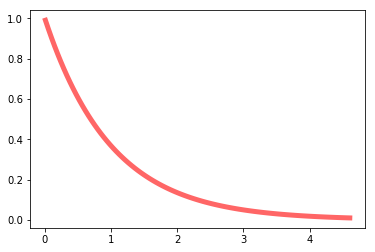

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
from scipy.stats import expon
x = np.linspace(expon.ppf(0.01),
                expon.ppf(0.99), 100)
ax.plot(x, expon.pdf(x),
       'r-', lw=5, alpha=0.6, label='expon pdf')

In [41]:
x = expon.rvs(loc = 0, scale = 1/5, size = 1000)
np.percentile(x, q=[0,95])

array([1.79792374e-04, 5.85099091e-01])

## Residual Analysis

In [135]:
# %%opts Bars {+axiswise} [width=1000, height=300, ] 
res = pd.DataFrame(np.mean(abs(np.mean(ps1['uu'], 0)),1))
res.columns = ['avg_u']
res.reset_index(inplace=True)
res.sort_values('avg_u', ascending=False, inplace=True)
hv.Bars(res[:20],).options(color='blue', xrotation=90).options(fig_inches=8, aspect=3)


:Bars   [index]   (avg_u)